In [183]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import numpy as np
import pypianoroll as pp
import torch.optim as optim

from glob import glob

from tqdm import tqdm

In [2]:
import sys
#sys.path.insert(0, "..")
sys.path.insert(0, "../..")

In [3]:
from smg.datasets.ldp_5_cleansed import LDP5Cleansed
from smg.models.recurrent import RecurrentSMG

In [4]:
def get_data_loader(dataset, batch_size, n_workers=4, shuffle=True):
    data_loader = torch.utils.data.DataLoader(
        dataset,
        num_workers=n_workers,
        batch_size=batch_size,
        drop_last=True,
        shuffle=shuffle
    )
    return data_loader


def experiment_config():
    n_pitches = 72
    beat_resolution = 4
    measures_per_sample = 4
    n_instruments = 5
    BEATS_PER_MEASURE = 4
    timesteps_per_measure = beat_resolution * BEATS_PER_MEASURE
    
    ds_args = {
        "data_dir": "../../../data/few_examples", #"../../../data/lpd_5",
        "lowest_pitch": 24,
        "n_pitches": n_pitches,
        "beat_resolution": beat_resolution,
        "measures_per_sample": measures_per_sample
    }
    dataset = LDP5Cleansed(**ds_args)
    
    
    batch_size = 8
    n_workers = 0
    data_loader = get_data_loader(dataset, batch_size, n_workers, shuffle=True)
    
    dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    hidden_size = 200
    num_layers = 3
    model = RecurrentSMG(timesteps_per_measure=timesteps_per_measure,
                n_pitches=n_pitches,
                n_instruments=n_instruments,
                seq_length=timesteps_per_measure * measures_per_sample,
                hidden_size=hidden_size,
                num_layers=num_layers)
    model = model.to(dev)
    
    return {"dataset": dataset, "data_loader": data_loader, "model": model, "dev": dev}


In [12]:
def run(dev, model, data_loader, num_epochs=10, lr=1e-2):
    
    opt = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    
    for epoch in range(1, num_epochs+1):
        pbar = tqdm(data_loader, desc="{:4d}. epoch".format(epoch))
        for x, y in pbar:
            x, y = x.to(dev), y.to(dev)
            
            opt.zero_grad()
            y_hat = model.forward(x)
            loss = loss_fn(y_hat, y) * 1e3
            loss.backward()
            opt.step()
            
            pbar.set_postfix(loss=loss.item())

In [13]:
config = experiment_config() 

ds = config["dataset"]
dl = config["data_loader"]
model = config['model']
dev = config['dev']

run(dev, model, dl, num_epochs=10, lr=1e-2)

   1. epoch:   0%|                                                                               | 0/4 [00:00<?, ?it/s]

Loaded 37 samples!


  10. epoch: 100%|████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.43it/s, loss=9.26]


In [469]:
# use model and generate a fuckn mid

# how you ask?
# well good question! let me tell you how

# start with a piano roll sequence
# should have dimension (batch_size, n_instruments, seq_length, n_pitches)
# batch size is 1, n_instrument is 5, n_pitches is 72
from torch.distributions.multinomial import Multinomial
from datetime import datetime


def generate_pianoroll(pianoroll, beat_resolution, lowest_pitch, n_pitches):
    '''
    :param pianoroll: uint8 array, shape = (instruments, time, 128) - min value = 0, max value = 127
    :param beat_resolution: don't touch this unless you know what you are doing
    :return: a multi track piano roll
    '''
    
    INSTRUMENTS = ['Drums', 'Piano', 'Guitar', 'Bass', 'Strings']
    INSTRUMENT_MIDI_METADATA = {
        0: (0, True),
        1: (0, False),
        2: (25, False),
        3: (33, False),
        4: (48, False)
    }

    tempo = 120.0
    downbeat=None

    assert(np.all(np.logical_and(pianoroll >= 0, pianoroll < 128)))
    pianoroll = pianoroll.astype(np.uint8)

    full_pitch_pianoroll = np.zeros((pianoroll.shape[0], pianoroll.shape[1], 128))
    full_pitch_pianoroll[:, :, lowest_pitch:lowest_pitch + n_pitches] = pianoroll

    # create tracks
    tracks = []
    for i in range(len(full_pitch_pianoroll)):
        program, is_drum = INSTRUMENT_MIDI_METADATA[i]
        tracks.append(
            pp.Track(
                full_pitch_pianoroll[i],
                is_drum=is_drum,
                program=program,
                name=INSTRUMENTS[i]
            )
        )

    # create multitrack piano rolls
    return pp.Multitrack(
        tracks=tracks,
        tempo=tempo * (np.ones(full_pitch_pianoroll.shape[1])),
        downbeat=downbeat,
        beat_resolution=beat_resolution,
        name='generated'
    )


def rand_stub_generator(seq_len):
    n_pitches = 72
    n_instruments = 5
    
    m = Multinomial(total_count=1, probs=torch.ones(1, n_instruments, seq_len, n_pitches))
    
    return lambda : m.sample()


def generate_mid(stub, model, n_iter=10, seq_length=None):
    if seq_length is None:
        seq_length = stub.size(2)
    
    pianoroll = stub
    
    for _ in range(n_iter):
        # generate next timestep
        y_hat = model.forward(stub)
        
        # add timestep to pianoroll
        pianoroll = torch.cat([pianoroll, y_hat], dim=2)
        # slide stub
        stub = pianoroll[:, :, -seq_len:, :]
        

    # convert pianoroll -> pp.Multitrack -> .mid file
    pianoroll_view = pianoroll.view(-1, pianoroll.size(3))
    max_p, argmax_p = pianoroll_view.max(dim=-1)
    
    new_roll = torch.zeros_like(pianoroll_view)
    new_roll[np.arange(new_roll.size(0)), argmax_p.type(torch.LongTensor)] = max_p
    
    pianoroll = new_roll.view(pianoroll.size())
    pianoroll = pianoroll.detach()[0].numpy() * 127
    
    pianoroll[np.logical_and(pianoroll > 1, pianoroll < 60)] += 60

    return generate_pianoroll(pianoroll, beat_resolution=4, lowest_pitch=24, n_pitches=72)

    
def stub_from_file(file, seq_length, random_start=True):
    lowest_pitch = 24
    n_pitches = 72
    n_instruments = 5
    beat_resolution = 4
    
    multitrack_roll = pp.load(file)
    multitrack_roll.downsample(multitrack_roll.beat_resolution // beat_resolution)
    
    stacked = multitrack_roll.get_stacked_pianoroll().transpose(2, 0, 1)
    
    start = 0 # np.random.choice(stacked.shape[1] - seq_length)
    if random_start:
        start = np.random.choice(stacked.shape[1] - seq_length)
     
    print(start)
    stub = stacked[:, start:start+seq_length, lowest_pitch:lowest_pitch+n_pitches]
    
    return torch.from_numpy(stub).type(dtype=torch.FloatTensor).unsqueeze(0) / 127

In [482]:
model.load_state_dict(torch.load('lstm_finished.pth', map_location=dev))

<All keys matched successfully>

In [483]:
data_dir = ds.data_dir
seq_len = 16*4

In [441]:
gen = rand_stub_generator(seq_len)
stub = gen()
sample = generate_mid(stub, model)

In [442]:
import pypianoroll.plot as ppplt

In [484]:
files = glob(data_dir + "/**/*.npz", recursive=True)

../../../data/few_examples\A\S\TRAASKZ128F9308820\886270e42b69e0983dfd9a591e66f214.npz
91


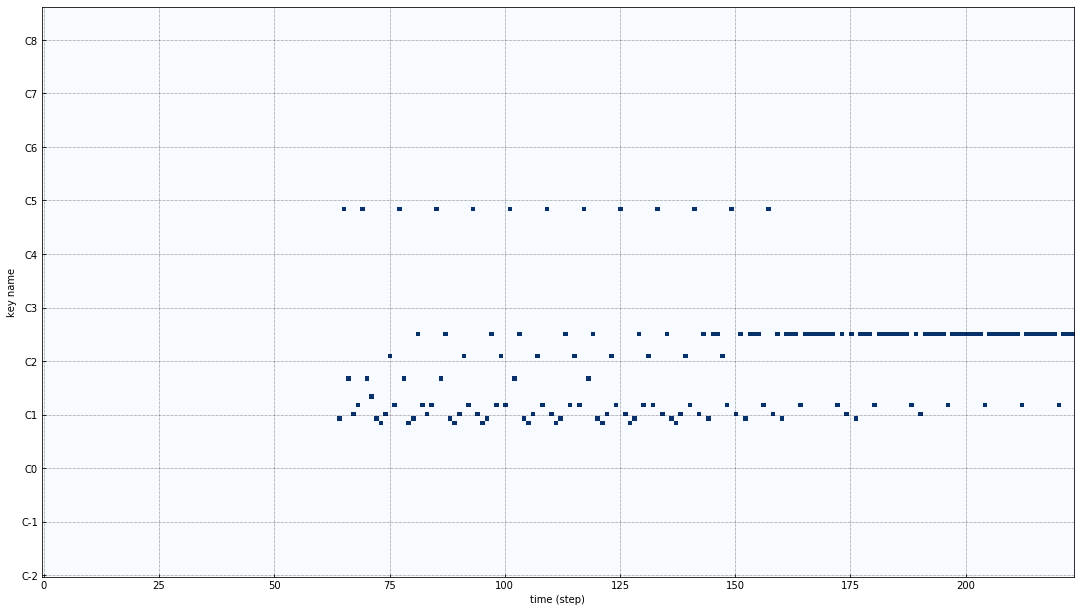

In [524]:
file = np.random.choice(files)
#file = files[]

print(file)
stub = stub_from_file(file, seq_len)
sample = generate_mid(stub, model, 10)
sample.write("../../../out/out_{}.mid".format(int(datetime.timestamp(datetime. now()))))

#sample.write('out.mid')
fig, axs = ppplt(sample.tracks[0])

fig.set_size_inches(18.5, 10.5)
plt.show()